## 1. Robot and Map classes


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 

In [2]:
import sys 
sys.path.append('.\src')

from main import *



MAIN


In [3]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 403e6256-30ac-42f4-bb1b-1c2b7dabf7d5

In [4]:

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }



while True:
    v = update_main()
    node.send_set_variables(v)
    #print(v)


In [2]:
def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

node.send_set_variables(motors(0,0))

In [ ]:
import cv2
import matplotlib.pyplot as plt


def generate_single_marker(aruco_dict):
   marker_size = int(input("Enter the marker size: "))
   marker_id = int(input("Enter the marker ID: "))

   marker_img = cv2.aruco.generateImageMarker(aruco_dict, marker_id,
    marker_size)

   cv2.imwrite("marker_{}.png".format(marker_id), marker_img)

   marker_img = cv2.imread("marker_{}.png".format(marker_id))

   cv2.imshow("Marker", marker_img)

   print("Dimensions:", marker_img.shape)

   cv2.waitKey(0)

def generate_bulk_markers(aruco_dict):
   marker_size = int(input("Enter the marker size: "))
   num_markers = int(input("Enter the number of markers to generate: "))
   marker_imgs = []

   for marker_id in range(num_markers):
       marker_img = cv2.aruco.generateImageMarker(aruco_dict, marker_id,marker_size)

       cv2.imwrite("marker_{}.png".format(marker_id), marker_img)
       marker_imgs.append(cv2.imread("marker_{}.png".format(marker_id)))

   for marker_img in marker_imgs:
       cv2.imshow("Marker", marker_img)
       print("Dimensions:", marker_img.shape)
       cv2.waitKey(0)

def main():
   aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)

   user_input = input("Press '1' to generate a single marker or "
                       "'2' to generate markers in bulk: ")

   if user_input == "1":
       generate_single_marker(aruco_dict)
   elif user_input == "2":
       generate_bulk_markers(aruco_dict)
   else:
       print("Invalid input. Please try again.")


main()



In [2]:
import numpy as np
matrix = np.zeros((4,4))
matrix[1,2] = 1
matrix[2,1] = 5
print(matrix)
matrix = np.rot90(matrix, k=1, axes=(0, 1))

print(matrix)

[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 5. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 5. 0.]
 [0. 0. 0. 0.]]


Path with direction changes: [(1, 1), (4, 1), (7, 4), (9, 4), (10, 5), (10, 10), (13, 13)]


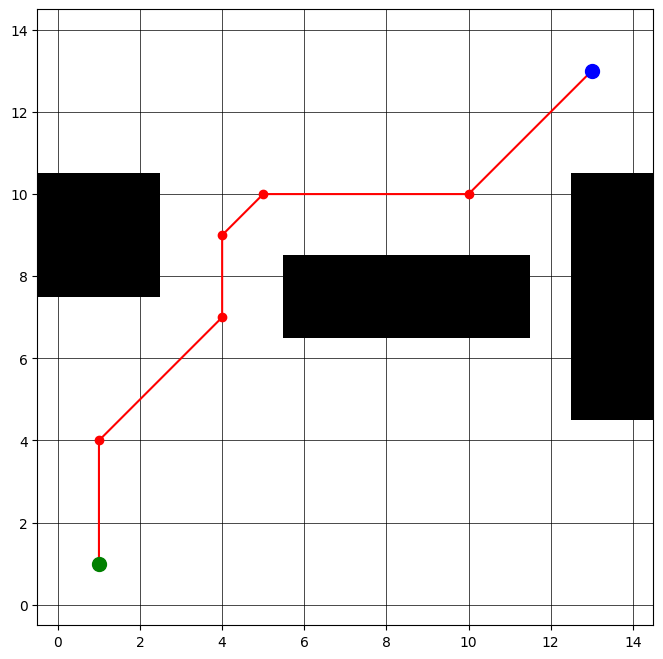

In [29]:
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

def is_valid(x, y, grid, robot_size):
    n = len(grid)
    for i in range(max(0, x - robot_size + 1), min(n, x + robot_size)):
        for j in range(max(0, y - robot_size + 1), min(n, y + robot_size)):
            if not (0 <= i < n and 0 <= j < n) or grid[i][j] == 1:
                return False
    return True

def find_shortest_path(grid, start, goal, robot_size):
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    queue = deque([(start, [])])
    visited = set()
    n = len(grid)

    while queue:
        (x, y), path = queue.popleft()
        if (x, y) == goal:
            return path + [(x, y)]

        if (x, y) not in visited and 0 <= x < n and 0 <= y < n:
            visited.add((x, y))
            for dx, dy in directions:
                new_x, new_y = x + dx, y + dy
                if is_valid(new_x, new_y, grid, robot_size) and 0 <= new_x < n and 0 <= new_y < n:
                    queue.append(((new_x, new_y), path + [(x, y)]))

    return None


def plot_grid(grid, path, start, goal):
    n = len(grid)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap='Greys', interpolation='nearest')

    if path:
        path_x, path_y = zip(*path)
        plt.plot(path_y, path_x, marker='o', color='red')

    plt.plot(start[1], start[0], marker='o', color='green', markersize=10)
    plt.plot(goal[1], goal[0], marker='o', color='blue', markersize=10)

    plt.xlim(-0.5, n - 0.5)
    plt.ylim(n - 0.5, -0.5)
    plt.gca().invert_yaxis()
    plt.grid(visible=True, color='black', linestyle='-', linewidth=0.5)
    plt.show()

def find_direction_changes(path):
    if len(path) <= 2:
        return path

    direction_changes = [path[0]]

    for i in range(2, len(path)):
        dx1 = path[i - 1][0] - path[i - 2][0]
        dy1 = path[i - 1][1] - path[i - 2][1]
        dx2 = path[i][0] - path[i - 1][0]
        dy2 = path[i][1] - path[i - 1][1]

        if (dx1, dy1) != (dx2, dy2):
            direction_changes.append(path[i - 1])

    direction_changes.append(path[-1])

    return direction_changes

# Example grid with obstacles

grid = np.array([
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0],
    [1 ,1 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,1],
    [1 ,1 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,1],
    [1 ,1 ,1 ,0 ,0 ,0 ,1 ,1 ,1 ,1 ,1 ,1 ,0 ,1 ,1],
    [0 ,0 ,0 ,0 ,0 ,0 ,1 ,1 ,1 ,1 ,1 ,1 ,0 ,1 ,1],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,1],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,1],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0],
    [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0]
    ])

#filp rows of grid
grid = np.flip(grid,0)

start_index = (1, 1)  # Replace with the index of your robot
goal_index = (13, 13)  # Replace with the index of your goal
robot_size = 2  # Replace with the size of your robot

path = find_shortest_path(grid, start_index, goal_index, robot_size)
if path:
    direction_changes_path = find_direction_changes(path)
    print("Path with direction changes:", direction_changes_path)
    plot_grid(grid, direction_changes_path, start_index, goal_index)
    # plot_grid(grid, path, start_index, goal_index)
else:
    print("No path found.")
